In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
import cv2
import subprocess
import re
import pickle

sys.path.append('..')

from utils import config
# from utils import utils

In [2]:
# >>> METHODS <<< #
def upsample_skeleton(skel, C=1):
    """
    skel: (3, joints, N)
    if the data is too short upsample to 100hz instead of 50hz
    """
    skel_measurements = skel.shape[2] # N
    
    inv_sampling_rate = 1 / config.ntu_fps
    time_window = skel_measurements * inv_sampling_rate

    skel_ts = np.linspace(0, time_window, skel_measurements) # time stamps for the skeleton data
    new_ts = np.linspace(0, time_window, int(config.mhad_accel_sampling_rate * time_window * C) + 1) # not clean at all this line. 

    skel_ts = np.round(skel_ts, 2)
    new_ts = np.round(new_ts, 2)
    
    skel_upsample = np.empty((skel.shape[0], skel.shape[1], new_ts.shape[0])) # (3, joints, M)
    for axis in range(skel.shape[0]):
        for joint in range(skel.shape[1]):
            f = interp1d(skel_ts, skel[axis, joint, :], kind='linear')
            skel_upsample[axis, joint, :] = f(new_ts)
    
    return skel_upsample

def normalize_skeleton(skel):
    """
    skel: (3, joints, N)
    """
    # Step 1: Extract MidHip (index 1) and Neck (index 10) coordinates
    midhip_coords = skel[:, 0, :]  # mid hip
    neck_coords = skel[:, 3, :]  # head

    # Step 2: center skeleton data
    skel = skel - midhip_coords[:, np.newaxis, :]

    # # Step 3: Calculate Euclidean distances for each sample N
    # distances = np.linalg.norm(neck_coords - midhip_coords, axis=0)

    # # Step 4: Calculate median distance using a sliding window of 2 seconds
    # median_distances = np.array(
    #     [np.median(distances[max(0, t-50):min(skel.shape[2], t+51)]) for t in range(skel.shape[2])])


    # # Step 5: Normalize all joints coordinates
    # # skel_normal = 2.0 * (skel / median_distances) - 1.0
    # if np.any(np.isnan(median_distances)) or np.any(median_distances == 0):
    #     return None

    # skel_normal = (skel / median_distances)

    skel_normal = skel
    
    return skel_normal

In [3]:
# >>> PLOTTING <<< #
def plot_joint_motion(pose, joint):
    fig, ax = plt.subplots(3, 1)
    fig.subplots_adjust(hspace=0.5)
    ax[0].plot(pose[0, joint, :], label="x")
    ax[0].legend()
    ax[1].plot(pose[1, joint, :], label="y")
    ax[1].legend()
    ax[2].plot(pose[2, joint, :], label="z")
    ax[2].legend()

    plt.show()


def compare_2_joints_motion(skel1, skel2, joint_idx=-1):
    """
    skel1: (3, N, joints=17)
    skel2: (3, N, joints=17)
    """
    fig, ax = plt.subplots(3, 1)
    fig.subplots_adjust(hspace=0.5)
    ax[0].plot(skel1[0, :, joint_idx], label="x", color='blue', alpha=0.5)
    ax[0].plot(skel2[0, :, joint_idx], label="x", color='red', alpha=0.5)
    ax[0].legend()
    ax[1].plot(skel1[1, :, joint_idx], label="y", color='blue', alpha=0.5)
    ax[1].plot(skel2[1, :, joint_idx], label="y", color='red', alpha=0.5)
    ax[1].legend()
    ax[2].plot(skel1[2, :, joint_idx], label="z", color='blue', alpha=0.5)
    ax[2].plot(skel2[2, :, joint_idx], label="z", color='red', alpha=0.5)
    ax[2].legend()

    plt.show()


def plot_skeleton(skel, frame=None):
    '''
    skel: (3, joint, N)
    '''
    motion = skel.transpose(1, 0, 2)  # (joints, 3, N)
    vlen = motion.shape[-1]

    #region Joint mappings
    # SPINEBASE 0
    # SPINEMID 1
    # NECK 2
    # HEAD 3
    # SHOULDERLEFT 4
    # ELBOWLEFT 5
    # WRISTLEFT 6
    # HANDLEFT 7
    # SHOULDERRIGHT 8
    # ELBOWRIGHT 9
    # WRISTRIGHT 10
    # HANDRIGHT 11
    # HIPLEFT 12
    # KNEELEFT 13
    # ANKLELEFT 14
    # FOOTLEFT 15
    # HIPRIGHT 16
    # KNEERIGHT 17
    # ANKLERIGHT 18
    # FOOTRIGHT 19
    # SPINESHOULDER 20
    # HANDTIPLEFT 21
    # THUMBLEFT 22
    # HANDTIPRIGHT 23
    # THUMBRIGHT 24
    #endregion

    joint_pairs = [
        [0, 1], [1, 20], [20, 2], [2, 3],  # spine
        [20, 4], [4, 5], [5, 6], [6, 7], [7, 21], [7, 22],  # left arm
        [20, 8], [8, 9], [9, 10], [10, 11], [11, 23], [11, 24],  # right arm
        [0, 12], [12, 13], [13, 14], [14, 15],  # left leg
        [0, 16], [16, 17], [17, 18], [18, 19]  # right leg
    ]
    joint_pairs_left = [
        [20, 4], [4, 5], [5, 6], [6, 7], [7, 21], [7, 22],  # left arm
        [20, 8], [8, 9], [9, 10], [10, 11], [11, 23], [11, 24],  # right arm
    ]
    joint_pairs_right = [
        [20, 4], [4, 5], [5, 6], [6, 7], [7, 21], [7, 22],  # left arm
        [20, 8], [8, 9], [9, 10], [10, 11], [11, 23], [11, 24],  # right arm
    ]

    color_mid = "#00457E"
    color_left = "#02315E"
    color_right = "#2F70AF"

    for f in range(vlen) if frame is None else [frame]:
        j3d = motion[:, :, f]
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(projection="3d")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=180., azim=90)

        ax.scatter(0, 0, 0, color='red', s=100)  # 's' is the size of the point

        plt.tick_params(left=False, right=False, labelleft=False,
                        labelbottom=False, bottom=False)

        for i in range(len(joint_pairs)):
            limb = joint_pairs[i]
            xs, ys, zs = [np.array([j3d[limb[0], j], j3d[limb[1], j]])
                          for j in range(3)]
            if joint_pairs[i] in joint_pairs_left:
                ax.plot(-xs, -ys, -zs, color=color_left, lw=3, marker='o', markerfacecolor='w',
                        markersize=3, markeredgewidth=2)  # axis transformation for visualization
            elif joint_pairs[i] in joint_pairs_right:
                ax.plot(-xs, -ys, -zs, color=color_right, lw=3, marker='o', markerfacecolor='w',
                        markersize=3, markeredgewidth=2)  # axis transformation for visualization
            else:
                ax.plot(-xs, -ys, -zs, color=color_mid, lw=3, marker='o', markerfacecolor='w',
                        markersize=3, markeredgewidth=2)  # axis transformation for visualization

            for j in range(j3d.shape[0]):
                x, y, z = j3d[j, 0], j3d[j, 1], j3d[j, 2]
                ax.text(-x, -y, -z, j, color='k', fontsize=10, weight='bold')

        fig.savefig(f'tmp/debug_frame_{f}.png')
        # frame_vis = get_img_from_fig(fig)
        # cv2.imwrite(f'tmp/debug_frame_{f}.png', frame_vis)  # Save the image to the provided path
        if frame is not None:
            plt.show()
        else:
            plt.close(fig)

In [4]:
# >>> PROCESSING <<< #
# skel3d_dir = os.path.join(config.ntu_data_dir, 'new_skel/')
skel3d_dir = config.ntu_data_dir
folders = sorted([f for f in os.listdir(skel3d_dir) if os.path.isdir(os.path.join(skel3d_dir, f))])

min_len = np.inf
min_name = ''
skels = []
for folder in folders:

    files = sorted([f for f in os.listdir(os.path.join(skel3d_dir, folder))])
    for file in files: 
        if not file.endswith('.npy') or file.endswith('norm.npy'):
            continue

        skel = np.load(os.path.join(skel3d_dir, folder, file)) # shape (3, joints, N)

        # 1) upsample
        if 30 <= skel.shape[2] < 60:
            skel_upsample = upsample_skeleton(skel, C=2) # upsample to 100Hz
        elif skel.shape[2] < 30:
            skel_upsample = upsample_skeleton(skel, C=3) # upsample to 150Hz
        else:
            skel_upsample = upsample_skeleton(skel) # upsample to 50 Hz

        # original_len = skel.shape[2]
        # upsampled_len = skel_upsample.shape[2]
        # print(f"{file}: {original_len} -> {upsampled_len}")

        # 3) normalize
        # continue if runtime warning rises
        skel_norm = normalize_skeleton(skel_upsample)
        if skel_norm is None:
            print(f"Error: {file} contains NaN or 0 values")
            continue

        if skel_norm.shape[2] < min_len:
            min_len = skel_norm.shape[2]
            min_name = file

        # 4) save file
        id = file.split('.')[0]
        np.save(os.path.join(skel3d_dir, folder, id + '_norm.npy'), skel_norm)
        # skels.append(skel_norm)

print(min_len, min_name)

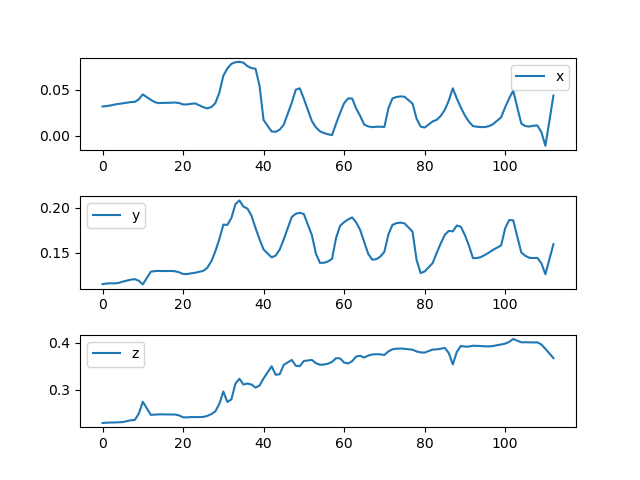

In [11]:
# plot_skeleton(skels[0])
plot_joint_motion(skels[4], 10)

In [5]:
# get fps of all videos
def get_fps_ffmpeg(video_path):
    # FFmpeg command to extract FPS and other info
    command = ['ffmpeg', '-i', video_path]
    
    # Run the command and capture the stderr (FFmpeg outputs info to stderr)
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    # Search for the fps in the output using regex
    fps_match = re.search(r'(\d+)\s+fps', result.stderr)
    
    if fps_match:
        fps = float(fps_match.group(1))
        return fps
    else:
        raise ValueError("Could not retrieve FPS. Please check the video file and FFmpeg output.")
    

# rgb_folder = os.path.join(config.ntu_data_dir, 'rgb/s1')
# rgb_files = os.listdir(rgb_folder)
# rgb_files = sorted(rgb_files)
# rgb_files = [os.path.join(rgb_folder, f) for f in rgb_files]
# min = np.inf
# max = -np.inf
# for f in rgb_files:
#     fps = get_fps_ffmpeg(f)
#     if fps < min:
#         min = fps
#     if fps > max:
#         max = fps
# print(min, max)

30.0 30.0
